In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import soundfile as sf

# Demonstration of using Farina method to obtain impedance magnitude and phase responses.

In [2]:
def logsweep(fmin,fmax,duration,sr,phi0=0):

    time = np.arange(0,duration,1/sr)
    omegaMin = fmin * 2 * np.pi
    omegaMax = fmax * 2 * np.pi

    phi = (omegaMin*duration)/np.log(omegaMax/omegaMin) * (np.exp(time/duration * np.log(omegaMax/omegaMin)) - 1) + phi0

    return np.sin(phi)

def inverseFilter(fmin,fmax,duration,sr,phi0=0):

    sweep = logsweep(fmin,fmax,duration,sr,phi0)
    time = np.arange(0,duration,1/sr)
 
    L = 1/fmin*(duration*fmin/(np.log(fmax/fmin)))
    normalisation = (np.exp(-time/L))/L*fmax*duration**2
    sweep_reverse = sweep[::-1] * normalisation
 
 
    return sweep_reverse

In [3]:
#generate swept sine and inverse filter
sr = 44100
fmin = 0.5
fmax = 10000
duration = 5

x = logsweep(fmin, fmax, duration, sr)

inv_x = inverseFilter(fmin, fmax, duration, sr)

sf.write('chirp_farina.wav', x, sr)

Text(0, 0.5, 'Ohms')

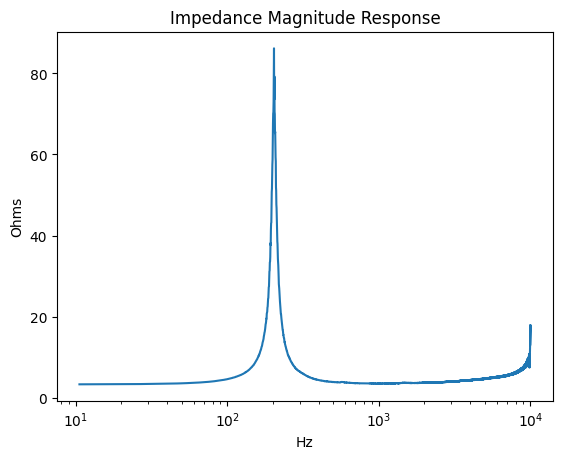

In [7]:
#Load file with current and voltage measurements in channel 0 and 1 respectively
y, sr = librosa.load('farina_iv.wav', sr=sr, mono=False)
#Scalings from datasheet
v = y[0] * 5.5
i = y[1] * 3

#Shift and scale IV so that V is full scale (-1 to 1) chirp.
corr = signal.correlate(v, x, 'valid')
shift = np.argmax(corr)
i = i[shift:] / np.max(v)
v = v[shift:] / np.max(v)

#Get acceptance (1/Z) impulse response by convolving current with inverse filter
h = signal.fftconvolve(inv_x * 2 / len(inv_x), i * 2 / len(i), 'valid')

index10k = np.where(np.fft.rfftfreq(len(h))*sr >= 10000)[0][0]
index10 = np.where(np.fft.rfftfreq(len(h))*sr >= 10)[0][0]

Z = 1 / np.fft.rfft(h) 

plt.plot((np.fft.rfftfreq(len(h))*sr)[index10:index10k], np.abs(Z)[index10:index10k])
plt.xscale('log')
plt.title("Impedance Magnitude Response")
plt.xlabel("Hz")
plt.ylabel("Ohms")

Text(0, 0.5, 'Rad')

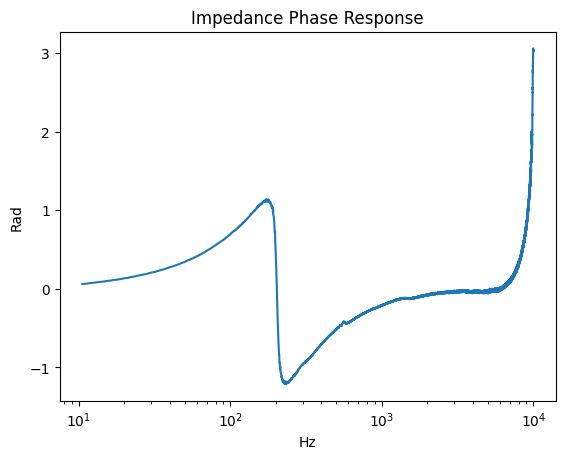

In [8]:
#Circular shift impulse response so that max amplitude is at index 0.
maxindex = np.argmax(h)
hshift = np.roll(h, -maxindex)

plt.plot((np.fft.rfftfreq(len(h))*sr)[index10:index10k], np.angle(1/np.fft.rfft(hshift))[index10:index10k])
plt.xscale('log')
plt.title("Impedance Phase Response")
plt.xlabel("Hz")
plt.ylabel("Rad")

Text(0, 0.5, 'Rad')

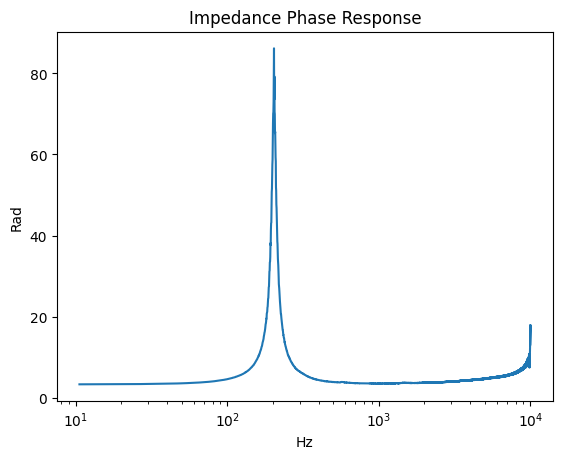

In [40]:
#Save impedance to text file and then read. First column is frequency (hz), second column is impedance (ohms)
Zshift = np.array(((np.fft.rfftfreq(len(h))*sr)[index10:index10k], 1/np.fft.rfft(hshift)[index10:index10k]))
np.savetxt('DAEX25Q-4.txt', Zshift)
Z_read = np.loadtxt('DAEX25Q-4.txt', dtype='complex128')

Text(0.5, 1.0, 'Magnitude Response of Scaled Conv(x, inv_x)')

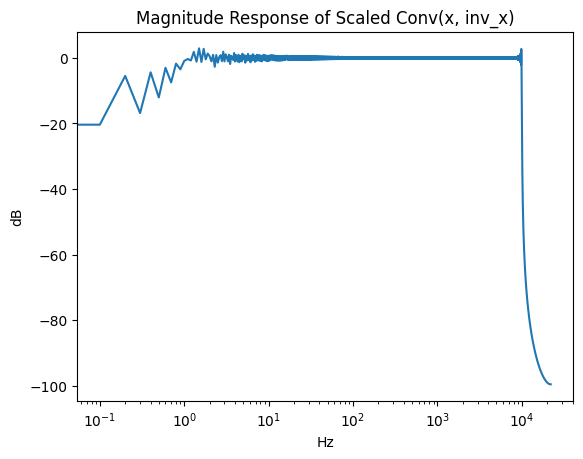

In [6]:
#Demonstration of scaling when convolving to obtain 0dB in frequencies of interest
h = signal.fftconvolve(inv_x * 2 / inv_x.size, x * 2 / x.size, 'full')

H = np.fft.rfft(h)
plt.plot(np.fft.rfftfreq(len(h)) * sr, 20*np.log10(np.abs(H)))
plt.xscale('log')
plt.xlabel('Hz')
plt.ylabel('dB')
plt.title("Magnitude Response of Scaled Conv(x, inv_x)")